In [1]:
import numpy as np
import torch

import deepinv as dinv
from deepinv.utils.plotting import plot
from deepinv.optim.data_fidelity import L2
from deepinv.utils.demo import load_url_image, get_image_url
from tqdm import tqdm, trange  # to visualize progress
from matplotlib.pyplot import plot as plot_

from Models import PMCPnP, PMCReD, PMCPnPAnnealing, PMCReDAnnealing
# from PMCPnP import PMCPnP
from utils import get_blur_physics, get_inpainting_physics
import cv2 as cv

device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

url = get_image_url("butterfly.png")
img_size = 256
x_true = load_url_image(url=url, img_size=img_size).to(device)
x = x_true.clone()

%load_ext autoreload
%autoreload 2

Selected GPU 0 with 14121 MB free memory 


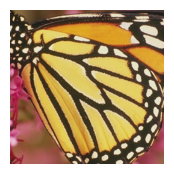

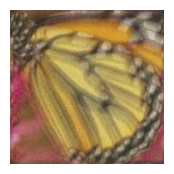

In [2]:
sigma = 0.05  # noise level

physics = get_blur_physics(sigma, device)

#physics = get_inpainting_physics(img_size, sigma, device)

torch.manual_seed(0)

# load Gaussian Likelihood

y = physics(x)
plot(x_true.detach().cpu())
plot(y)

# Classic (no annealing)

## Random

In [109]:
gamma = 5e-4
alpha = 1
iterations = int(500) if torch.cuda.is_available() else 10
sigma_denoiser = np.sqrt(2 * gamma) * 1.5
# sigma_denoiser = .01
print(gamma)
print(sigma_denoiser)

likelihood = dinv.optim.L2(sigma=sigma_denoiser)

prior = dinv.optim.ScorePrior(
    # denoiser=dinv.models.DRUNet(pretrained="download")
    denoiser=dinv.models.DiffUNet(pretrained="download", large_model=False)
).to(device)


pmc_pnp = PMCPnP(prior=prior,
                 data_fidelity=likelihood,
                 max_iter=iterations,
                 gamma=gamma,
                 sigma=sigma_denoiser,
                 alpha=alpha,
                 deterministic = False,)

pmc_red = PMCReD(prior=prior,
                 data_fidelity=likelihood,
                 max_iter=iterations,
                 gamma=gamma,
                 sigma=sigma_denoiser,
                 alpha=alpha,
                 deterministic = False,)

0.0005
0.04743416490252569


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:21<00:00, 23.00it/s]


Monte Carlo sampling finished! elapsed time=21.76 seconds
Iteration 499, current converge crit. = 4.16E-04, objective = 1.00E-03 


100%|██████████| 500/500 [00:21<00:00, 22.84it/s]


Monte Carlo sampling finished! elapsed time=21.90 seconds
Iteration 499, current converge crit. = 4.24E-04, objective = 1.00E-03 
Linear reconstruction PSNR: 14.78 dB
PreconULA posterior mean PSNR: 27.42 dB


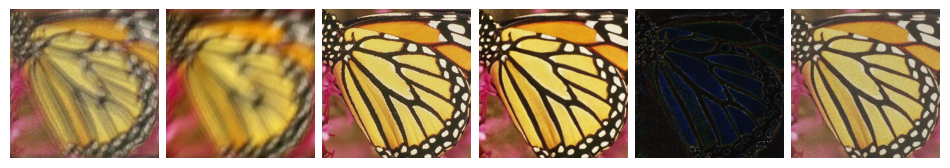

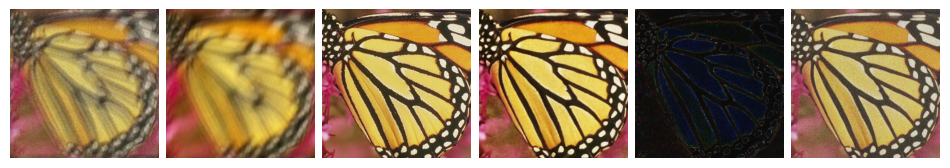

In [110]:
### ça fait de la d 

pula_mean_pnp, pula_var_pnp = pmc_pnp(y, physics)
pula_mean_red, pula_var_red = pmc_red(y, physics)

# compute linear inverse
x_lin = physics.A_adjoint(y)
# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(
    f"PreconULA posterior mean PSNR: {dinv.utils.metric.cal_psnr(x, pula_mean):.2f} dB"
)

example_sample_pnp = pula_mean + torch.randn_like(pula_mean_pnp) * torch.sqrt(pula_var_pnp)
example_sample_red = pula_mean + torch.randn_like(pula_mean_red) * torch.sqrt(pula_var_red)


# plot results
imgs = [y, x_lin, x, pula_mean_pnp, pula_var_pnp, example_sample_pnp]
plot(imgs)
imgs = [y, x_lin, x, pula_mean_red, pula_var_red, example_sample_red]
plot(imgs)

## Deterministic

In [103]:
gamma = 5e-4
alpha = 1
iterations = int(500) if torch.cuda.is_available() else 10
sigma_denoiser = np.sqrt(2 * gamma) * 1.5
# sigma_denoiser = .01
print(gamma)
print(sigma_denoiser)

likelihood = dinv.optim.L2(sigma=sigma_denoiser)

prior = dinv.optim.ScorePrior(
    # denoiser=dinv.models.DRUNet(pretrained="download")
    denoiser=dinv.models.DiffUNet(pretrained="download", large_model=False)
).to(device)


pmc_pnp = PMCPnP(prior=prior,
                 data_fidelity=likelihood,
                 max_iter=iterations,
                 gamma=gamma,
                 sigma=sigma_denoiser,
                 alpha=alpha,
                 deterministic = True,)

pmc_red = PMCReD(prior=prior,
                 data_fidelity=likelihood,
                 max_iter=iterations,
                 gamma=gamma,
                 sigma=sigma_denoiser,
                 alpha=alpha,
                 deterministic = True,)

0.0005
0.04743416490252569


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:21<00:00, 23.03it/s]


Monte Carlo sampling finished! elapsed time=21.73 seconds
Iteration 499, current converge crit. = 1.87E-04, objective = 1.00E-03 


100%|██████████| 500/500 [00:21<00:00, 22.84it/s]


Monte Carlo sampling finished! elapsed time=21.90 seconds
Iteration 499, current converge crit. = 1.87E-04, objective = 1.00E-03 
Linear reconstruction PSNR: 14.78 dB
PreconULA posterior mean PSNR: 27.42 dB


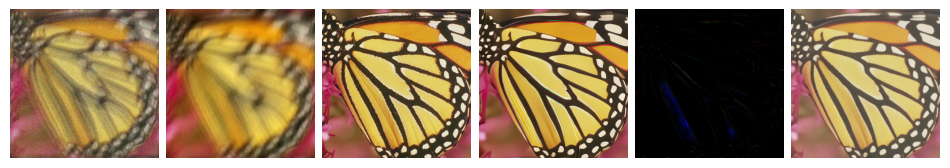

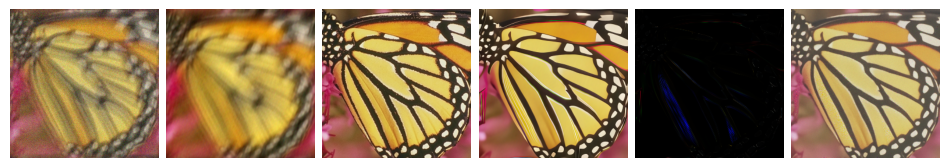

In [104]:
### ça fait de la d 

pula_mean_pnp, pula_var_pnp = pmc_pnp(y, physics)
pula_mean_red, pula_var_red = pmc_red(y, physics)

# compute linear inverse
x_lin = physics.A_adjoint(y)
# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(
    f"PreconULA posterior mean PSNR: {dinv.utils.metric.cal_psnr(x, pula_mean):.2f} dB"
)

example_sample_pnp = pula_mean + torch.randn_like(pula_mean_pnp) * torch.sqrt(pula_var_pnp)
example_sample_red = pula_mean + torch.randn_like(pula_mean_red) * torch.sqrt(pula_var_red)


# plot results
imgs = [y, x_lin, x, pula_mean_pnp, pula_var_pnp, example_sample_pnp]
plot(imgs)
imgs = [y, x_lin, x, pula_mean_red, pula_var_red, example_sample_red]
plot(imgs)

# Annealing 

In [212]:
def exponential_decay_alpha(alpha_0, alpha_final, iterations):
    # decay_rate = 1 / alpha_0
    decay_rate = .975
    t_values = torch.range(0, iterations-1)
    alphas = alpha_0 * (decay_rate ** t_values)
    alphas[alphas < alpha_final] = alpha_final
    return alphas

def exponential_decay_sigma(sigma_0, sigma_final, iterations):
    decay_rate = .975
    t_values = torch.range(0, iterations-1)
    sigmas = sigma_0 * (decay_rate ** t_values)
    sigmas[sigmas < sigma_final] = sigma_final
    return sigmas

## Random

In [225]:
iterations = int(1500) if torch.cuda.is_available() else 10

# Set parameters
gamma = 5e-4
alpha_0, alpha_final = 10, 1
sigma_denoiser = np.sqrt(2 * gamma) * 1.5
# sigma_denoiser = .05
sigma_0, sigma_final = 10, sigma_denoiser

print(sigma_denoiser)
# Generate alpha values: linearly decreasing from alpha_0 to 1
# alphas = torch.linspace(alpha_0, 1, iterations)
alphas = exponential_decay_alpha(alpha_0, alpha_final, iterations)

# Generate sigma values: linearly decreasing from sigma_0 to sigma_final
# sigmas = torch.linspace(sigma_0, sigma_final, iterations)
sigmas = exponential_decay_sigma(sigma_0, sigma_final, iterations)

likelihood = dinv.optim.L2(sigma=sigma_denoiser)

prior = dinv.optim.ScorePrior(
    # denoiser=dinv.models.DRUNet(pretrained="download")
    denoiser=dinv.models.DiffUNet(pretrained="download", large_model=False)
).to(device)

pmc_pnp = PMCPnPAnnealing(prior=prior,
                 data_fidelity=likelihood,
                 max_iter=iterations,
                 gamma=gamma,
                 sigmas=sigmas,
                 alphas=alphas,
                #  burnin_ratio = .7,
                 deterministic = False,)

pmc_red = PMCReDAnnealing(prior=prior,
                 data_fidelity=likelihood,
                 max_iter=iterations,
                 gamma=gamma,
                 sigmas=sigmas,
                 alphas=alphas,
                #  burnin_ratio = .7,
                 deterministic = False,)

0.04743416490252569


/tmp/ipykernel_1874373/3378550085.py:4: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  t_values = torch.range(0, iterations-1)
/tmp/ipykernel_1874373/3378550085.py:11: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  t_values = torch.range(0, iterations-1)


  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [01:09<00:00, 21.66it/s]


Monte Carlo sampling finished! elapsed time=69.28 seconds
Iteration 1499, current converge crit. = 1.51E-04, objective = 1.00E-03 


100%|██████████| 1500/1500 [01:09<00:00, 21.57it/s]


Monte Carlo sampling finished! elapsed time=69.56 seconds
Iteration 1499, current converge crit. = 1.53E-04, objective = 1.00E-03 
Linear reconstruction PSNR: 14.78 dB
PreconULA posterior mean PSNR: 27.42 dB


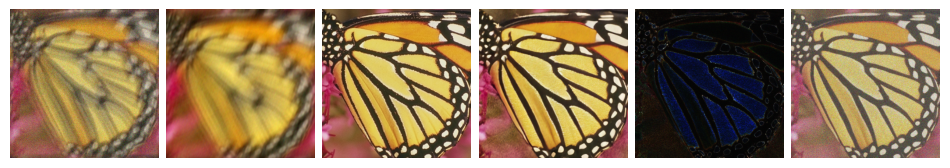

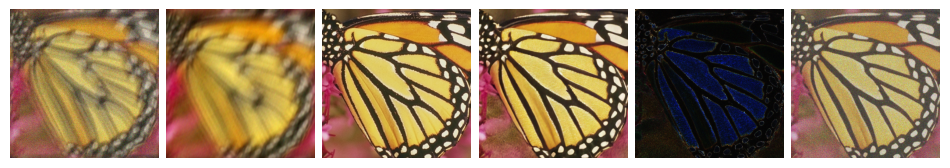

In [226]:
### ça fait de la d 

pula_mean_pnp, pula_var_pnp = pmc_pnp(y, physics)
pula_mean_red, pula_var_red = pmc_red(y, physics)

# compute linear inverse
x_lin = physics.A_adjoint(y)
# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(
    f"PreconULA posterior mean PSNR: {dinv.utils.metric.cal_psnr(x, pula_mean):.2f} dB"
)

example_sample_pnp = pula_mean + torch.randn_like(pula_mean_pnp) * torch.sqrt(pula_var_pnp)
example_sample_red = pula_mean + torch.randn_like(pula_mean_red) * torch.sqrt(pula_var_red)


# plot results
imgs = [y, x_lin, x, pula_mean_pnp, pula_var_pnp, example_sample_pnp]
plot(imgs)
imgs = [y, x_lin, x, pula_mean_red, pula_var_red, example_sample_red]
plot(imgs)

## Deterministic

In [229]:
iterations = int(500) if torch.cuda.is_available() else 10

# Set parameters
gamma = 5e-4
alpha_0, alpha_final = 10, 1
sigma_denoiser = np.sqrt(2 * gamma) * 1.5
# sigma_denoiser = .05
sigma_0, sigma_final = 10, sigma_denoiser

print(sigma_denoiser)
# Generate alpha values: linearly decreasing from alpha_0 to 1
# alphas = torch.linspace(alpha_0, 1, iterations)
alphas = exponential_decay_alpha(alpha_0, alpha_final, iterations)

# Generate sigma values: linearly decreasing from sigma_0 to sigma_final
# sigmas = torch.linspace(sigma_0, sigma_final, iterations)
sigmas = exponential_decay_sigma(sigma_0, sigma_final, iterations)

likelihood = dinv.optim.L2(sigma=sigma_denoiser)

prior = dinv.optim.ScorePrior(
    # denoiser=dinv.models.DRUNet(pretrained="download")
    denoiser=dinv.models.DiffUNet(pretrained="download", large_model=False)
).to(device)

pmc_pnp = PMCPnPAnnealing(prior=prior,
                 data_fidelity=likelihood,
                 max_iter=iterations,
                 gamma=gamma,
                 sigmas=sigmas,
                 alphas=alphas,
                #  burnin_ratio = .7,
                 deterministic = True,)

pmc_red = PMCReDAnnealing(prior=prior,
                 data_fidelity=likelihood,
                 max_iter=iterations,
                 gamma=gamma,
                 sigmas=sigmas,
                 alphas=alphas,
                #  burnin_ratio = .7,
                 deterministic = True,)

0.04743416490252569


/tmp/ipykernel_1874373/3378550085.py:4: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  t_values = torch.range(0, iterations-1)
/tmp/ipykernel_1874373/3378550085.py:11: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  t_values = torch.range(0, iterations-1)


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:22<00:00, 21.80it/s]


Monte Carlo sampling finished! elapsed time=22.95 seconds
Iteration 499, current converge crit. = 4.74E-04, objective = 1.00E-03 


100%|██████████| 500/500 [00:23<00:00, 21.68it/s]


Monte Carlo sampling finished! elapsed time=23.08 seconds
Iteration 499, current converge crit. = 4.79E-04, objective = 1.00E-03 
Linear reconstruction PSNR: 14.78 dB
PreconULA posterior mean PSNR: 27.42 dB


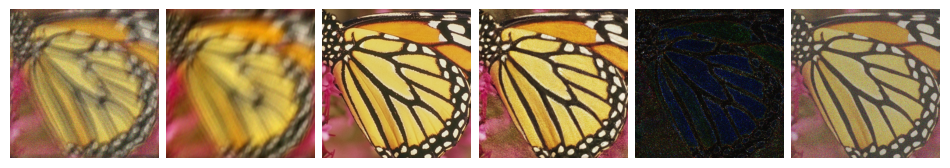

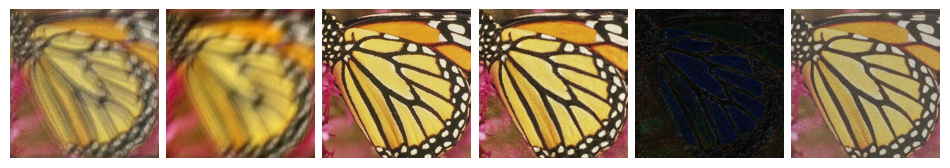

In [230]:
### ça fait de la d 

pula_mean_pnp, pula_var_pnp = pmc_pnp(y, physics)
pula_mean_red, pula_var_red = pmc_red(y, physics)

# compute linear inverse
x_lin = physics.A_adjoint(y)
# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(
    f"PreconULA posterior mean PSNR: {dinv.utils.metric.cal_psnr(x, pula_mean):.2f} dB"
)

example_sample_pnp = pula_mean + torch.randn_like(pula_mean_pnp) * torch.sqrt(pula_var_pnp)
example_sample_red = pula_mean + torch.randn_like(pula_mean_red) * torch.sqrt(pula_var_red)


# plot results
imgs = [y, x_lin, x, pula_mean_pnp, pula_var_pnp, example_sample_pnp]
plot(imgs)
imgs = [y, x_lin, x, pula_mean_red, pula_var_red, example_sample_red]
plot(imgs)

# Toy Experience

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm
import seaborn as sns
sns.set()

In [2]:
def kl_divergence_gaussian(mu1, sigma1, mu2, sigma2):
    """
    Compute the KL divergence between two Gaussian distributions.
    
    Parameters:
    - mu1, sigma1: Mean and standard deviation of the first Gaussian distribution.
    - mu2, sigma2: Mean and standard deviation of the second Gaussian distribution.
    
    Returns:
    - KL divergence between the two distributions.
    """
    return np.log(sigma2 / sigma1) + (sigma1**2 + (mu1 - mu2)**2) / (2 * sigma2**2) - 0.5


kl_divergence = kl_divergence_gaussian(0, 1, 2, 1.5)
kl_divergence

1.0165762192192755

In [ ]:
def iterations(y, x_0, gamma, beta, std_noise, alpha, tau, mu, iter_max):
    n_trajectories = 10000
    res = np.zeros((n_trajectories, iter_max + 1))
    res[:,0] = np.ones(n_trajectories) * x_0 
    x = x_0

    for iter in range(iter_max):
        # G = -(alpha / beta ** 2) * (y - alpha * x)
        # G += - (std_noise ** 2 / gamma) * (-1 / (std_noise ** 2 + tau ** 2)) * (x - mu)
        # G += - (std_noise ** 2) * (-1 / (std_noise ** 2 + tau ** 2)) * (x - mu)
        noise = np.sqrt(2 * gamma) * np.random.randn(n_trajectories)
        # x = x - gamma * G + noise 
        x = x - gamma * (y-x) / beta**2 - std_noise**2*(x - mu) / (std_noise**2 + tau**2) + noise
        res[:,iter+1] = x

    return res 

In [8]:
#### parameters 
alpha = 1
beta = .1
mu, tau = 2, 1
x = mu 
noise = torch.randn(1) * beta
y = x + noise

gamma, std_noise, iter_max = 1e-4, 5, 1000

In [4]:
# mean_post, std_post = y / beta ** 2 + mu / tau**2, 1 / ((1/beta**2) + (1 / tau**2))
mean_post, std_post = y * (tau**2) / (tau**2 + beta**2) + mu * (beta**2) / (tau**2 + beta**2), np.sqrt(1 / ((1/beta**2) + (1 / tau**2)))

mean_post, std_post

(tensor([1.9811]), 0.09950371902099893)

In [25]:
x_0 = mu + 10
trajectories = iterations_2(y, x_0, gamma, beta, std_noise, alpha, tau, mu, iter_max)

In [12]:
kls = []
gammas = np.linspace(0, 1e-2, 100)
for gamma in tqdm(gammas):
    trajectories = iterations_2(y, x_0, gamma, beta, std_noise, alpha, tau, mu, iter_max = 500)
    kls.append(kl_divergence_gaussian(mu1 = np.mean(trajectories[:,-1]), sigma1 = np.std(trajectories[:,-1]), mu2 = mean_post, sigma2 = std_post))


  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_431361/101054104.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return np.log(sigma2 / sigma1) + (sigma1**2 + (mu1 - mu2)**2) / (2 * sigma2**2) - 0.5
100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


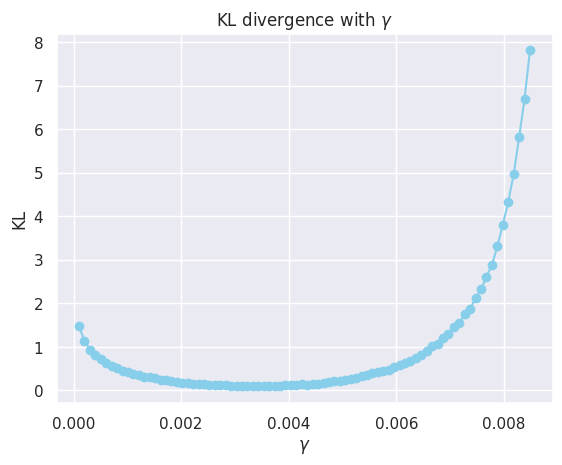

In [13]:
plt.plot(gammas[:-15], kls[:-15], color='skyblue', marker='o', linestyle='-')

# Adding labels and title
plt.title('KL divergence with $\gamma$')
plt.xlabel('$\gamma$')
plt.ylabel('KL')

# Adding grid for better readability
plt.grid(True)

# Displaying the plot
plt.show()

In [16]:
kls[34], gammas[34]

(tensor([0.0901]), 0.0034343434343434343)

In [26]:
gamma = gammas[34]
res = iterations_2(y, x_0, gamma, beta, std_noise, alpha, tau, mu, iter_max = 500)

In [27]:
kls_t = []
for idx in range(res.shape[1]):
    kls_t.append(kl_divergence_gaussian(mu1 = np.mean(trajectories[:,idx]), sigma1 = np.std(trajectories[:,idx]), mu2 = mean_post, sigma2 = std_post))


/tmp/ipykernel_431361/101054104.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return np.log(sigma2 / sigma1) + (sigma1**2 + (mu1 - mu2)**2) / (2 * sigma2**2) - 0.5


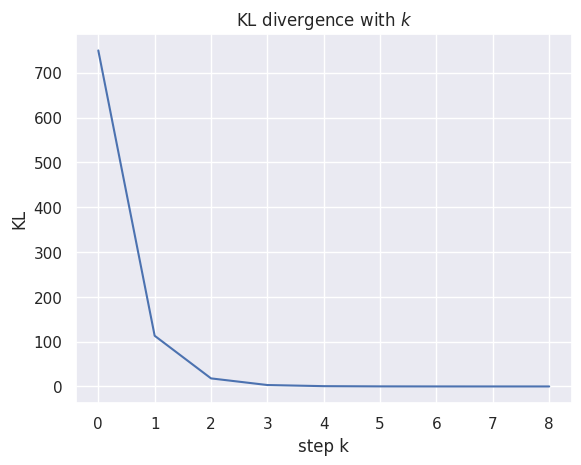

In [33]:
plt.plot(kls_t[1:10])

# Adding labels and title
plt.title('KL divergence with $k$')
plt.xlabel('step k')
plt.ylabel('KL')

# Adding grid for better readability
plt.grid(True)

# Displaying the plot
plt.show()
